# model 3

In [29]:
# Run development environment checks for gpu compute
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Is built with CUDA:", tf.test.is_built_with_cuda())
print("GPUs detected:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
Is built with CUDA: True
GPUs detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
# Run pip dependency fallback checks if needed
#!pip install gensim

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 44.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 KB 10.8 MB/s eta 0:00:00


In [19]:
#!pip install seaborn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 KB 5.3 MB/s eta 0:00:00a 0:00:01


In [34]:
import os
import random
import numpy as np
import datasets
import tensorflow as tf
from datasets import load_dataset
from gensim.models import Word2Vec
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall, AUC

# Load dataset
dataset_dict = load_dataset("deepcopy/MathWriting-human")

# Set this config for percentage of the data
USE_PERCENTAGE = 0.10
train_samples = int(USE_PERCENTAGE * len(dataset_dict["train"]))
val_samples = int(USE_PERCENTAGE * len(dataset_dict["val"]))

train_small = dataset_dict["train"].select(range(train_samples))
val_small = dataset_dict["val"].select(range(val_samples))

# Add binary_label
latex_pool = train_small["latex"]

def add_binary_label(example):
    if random.random() > 0.5:
        example["binary_label"] = 1
        example["latex_used"] = example["latex"]
    else:
        wrong_latex = random.choice(latex_pool)
        while wrong_latex == example["latex"]:
            wrong_latex = random.choice(latex_pool)
        example["binary_label"] = 0
        example["latex_used"] = wrong_latex
    return example

train_small = train_small.map(add_binary_label)
val_small = val_small.map(add_binary_label)

# Tokenization (basic whitespace split. No tokenization mechanism really)
def tokenize(text):
    return text.split()

# Prepare corpus
corpus = [tokenize(ex["latex_used"]) for ex in train_small]

# Train Word2Vec
w2v = Word2Vec(sentences=corpus, vector_size=100, window=5, min_count=1, workers=4)

# Build vocab + index mapping
word_index = {word: idx + 1 for idx, word in enumerate(w2v.wv.index_to_key)}  # 0 reserved for padding
embedding_matrix = np.zeros((len(word_index) + 1, 100))
for word, i in word_index.items():
    embedding_matrix[i] = w2v.wv[word]

# Convert LaTeX to padded index sequences
def text_to_sequence(text):
    return [word_index.get(word, 0) for word in tokenize(text)]

maxlen = 64  # Set based on train/validation/testing

def encode_dataset(hf_dataset):
    X = [text_to_sequence(ex["latex_used"]) for ex in hf_dataset]
    X_pad = pad_sequences(X, maxlen=maxlen)
    y = np.array([ex["binary_label"] for ex in hf_dataset]).astype(np.float32)
    return X_pad, y

X_train, y_train = encode_dataset(train_small)
X_val, y_val = encode_dataset(val_small)

# Build model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights=[embedding_matrix],
        input_length=maxlen,
        trainable=False
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model._name = "model_3"
model._handle_name = "model_3"

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=16
)

Epoch 1/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 38s 24ms/step - accuracy: 0.5058 - loss: 0.6933 - val_accuracy: 0.5220 - val_loss: 0.6927
Epoch 2/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.5032 - loss: 0.6932 - val_accuracy: 0.4780 - val_loss: 0.6933
Epoch 3/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.4972 - loss: 0.6933 - val_accuracy: 0.4780 - val_loss: 0.6940
Epoch 4/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.5003 - loss: 0.6933 - val_accuracy: 0.4780 - val_loss: 0.6934
Epoch 5/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 32s 22ms/step - accuracy: 0.5031 - loss: 0.6931 - val_accuracy: 0.5227 - val_loss: 0.6931
Epoch 6/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 31s 21ms/step - accuracy: 0.5011 - loss: 0.6932 - val_accuracy: 0.5220 - val_loss: 0.6930
Epoch 7/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.5065 - loss: 0.6931 - val_accuracy: 0.4780 - val_loss: 0.6940
Epoch 8/10
1437/1437 ━━━━━━━━━━━━━━━━━━━━ 35s 24ms/step - accuracy: 0.4962 -

In [35]:
# Model summary
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 64, 100)        │     1,183,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 128)            │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,461,905 (5.58 MB)

 Trainable params: 92,801 (362.50 KB)

 Non-trainable params: 1,183,500 (4.51 MB)

 Optimizer params: 185,604 (725.02 KB)

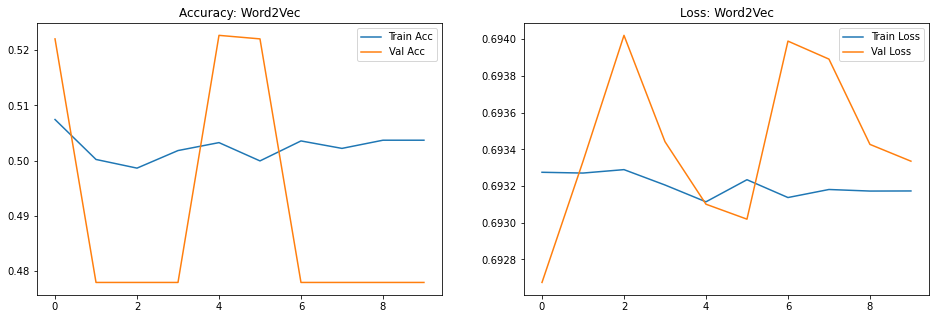

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy: Word2Vec')

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss: Word2Vec')

plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step
              precision    recall  f1-score   support

         0.0     0.4780    1.0000    0.6468       749
         1.0     0.0000    0.0000    0.0000       818

    accuracy                         0.4780      1567
   macro avg     0.2390    0.5000    0.3234      1567
weighted avg     0.2285    0.4780    0.3092      1567



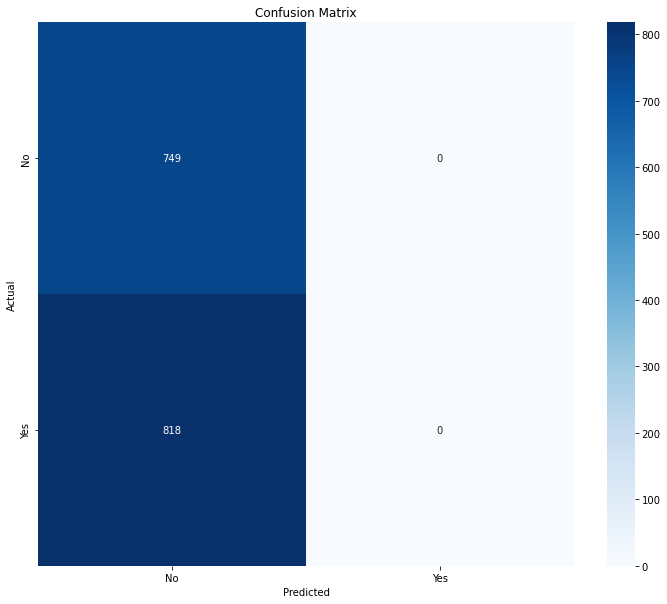

In [37]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns

# Predict probabilities and threshold
y_pred_prob = model.predict(X_val).flatten()
y_pred = (y_pred_prob > 0.5).astype(int)

# Report
print(classification_report(y_val, y_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "Yes"], yticklabels=["No", "Yes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [26]:
from keras.callbacks import Callback
from sklearn.metrics import f1_score
import numpy as np

class F1Callback(Callback):
    def __init__(self, val_data):
        super().__init__()
        self.val_data = val_data  # tf.data.Dataset

    def on_epoch_end(self, epoch, logs=None):
        y_true = []
        y_pred = []

        for batch in self.val_data:
            X_batch, y_batch = batch
            logits = self.model.predict(X_batch, verbose=0)
            probs = tf.sigmoid(logits).numpy().flatten()
            preds = (probs > 0.5).astype(int)

            y_true.extend(y_batch.numpy())
            y_pred.extend(preds)

        f1 = f1_score(y_true, y_pred)
        print(f"\nEpoch {epoch+1} F1 Score: {f1:.4f}")

"""
For F1 scores. We can add this into model callbacks
Example usage:
f1_cb = F1Callback(tf_val)

history = model.fit(
    tf_train,
    validation_data=tf_val,
    epochs=5,
    callbacks=[f1_cb]
)
"""

In [40]:
# Save builds
model.save("models/model3.h5")
model.save("models/model3.kears")

In [ ]:
# end of model 3 build and test runs

The results of Word2Vec are not what I had expected. Overall requires further research and work.